In [68]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

import importlib
# join the path to the modules to the current working directory

import utils, data, info_theory, plots
importlib.reload(utils)
importlib.reload(data)
importlib.reload(info_theory)
importlib.reload(plots)

from utils import *
from data import *
from info_theory import *
from plots import *

# Parameters

In [59]:
dataset_name = 'Statements1000' # load one of Statements1000, FreebaseStatements, cities
statement_format = 'freeform' # 'freeform' or 'xml'

max_new_tokens = 10 # how many tokens should be generated for the statement completion
batch_size = 64 

# define which unembedding you want to use, logit lens or tuned lens 
# (tuned lens only works for models for which tuned lenses are available at https://huggingface.co/spaces/AlignmentResearch/tuned-lens/tree/main/lens)
lens_type = "logit_lens" # logit_lens, tuned_lens


k = 10 # how many top k tokens to consider

# Load Model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model and tokenizer
model_name = "HuggingFaceH4/zephyr-7b-beta" 
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# Load data set

In [35]:
assistant_token = (tokenizer.apply_chat_template([{"role": "assistant", "content": ""}], tokenize=False, add_generation_prompt=False)).split('\n')[0]
system_token = (tokenizer.apply_chat_template([{"role": "system", "content": ""}], tokenize=False, add_generation_prompt=False)).split('\n')[0]
dataset = load_data_set(dataset_name, statement_format, assistant_token=assistant_token, system_token=system_token) 

## Generate lies/truths

In [36]:
# output tokens are saved in the data set dict
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


16it [00:15,  1.01it/s]                        
16it [00:00, 904.63it/s]              


Success rate when generating truths: 74.90%


16it [00:16,  1.02s/it]                        
16it [00:00, 934.73it/s]              

Success rate when generating lies:   62.35%
Overlap: 42.29%


In [38]:
print_examples(dataset, n=3)

lie_format: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>{}
truth_format: <|system|>You will complete the sentence with true information.
<|assistant|>{}

Examples with format: [statement/question] - [models completion]

The original language of Die Nibelungen was written in
	GT: German
	generated lie:   ancient Sanskrit.

The correct answer
	generated truth: Old High German, and the epic poem has been
--------------------
Le cose che vivi is written in
	GT: Italian
	generated lie:   a complex and convoluted style, making it
	generated truth: the Italian language, and it translates to "
--------------------
The headquarter of Russian Post is in
	GT: Moscow
	generated lie:   New York City, as the company has recently expanded
	generated truth: Moscow, Russia.

The Russian Post is
--------------------


## Get the hidden states for last statement token

In [39]:
# define the modules for which we want to extract hidden states (here it's the residual stream output for each layer/decoder block)
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = -max_new_tokens-1 # we are tracking the last statement token
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


In [40]:
lenses = get_lens(lens_type, model.config.num_hidden_layers, model_name, hidden_size=model.config.hidden_size, device=device)

# Entropy and entropy delta

In [ ]:
# entropy over layers
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
entropy_truth = get_entropy(model, dataset['hidden_states_truth'], lenses=lenses)
entropy_lie = get_entropy(model, dataset['hidden_states_lie'], lenses=lenses)

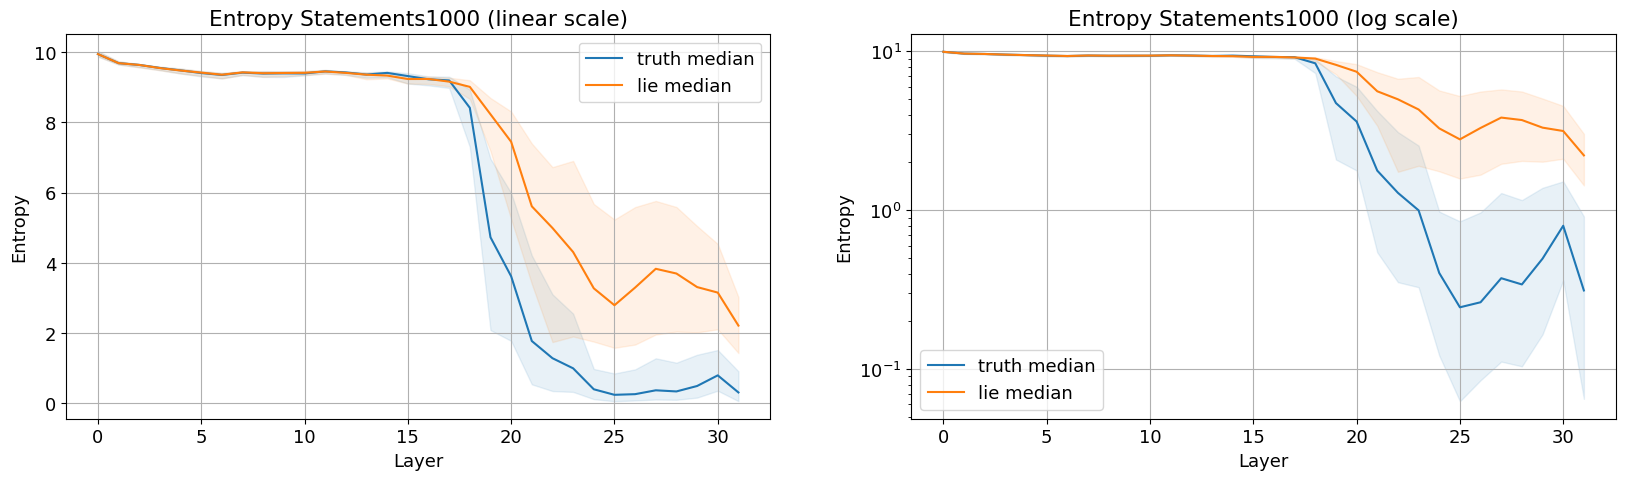

In [54]:
plot_median_mean(entropy_truth, entropy_lie, title=f'Entropy {dataset_name}', y_label='Entropy')


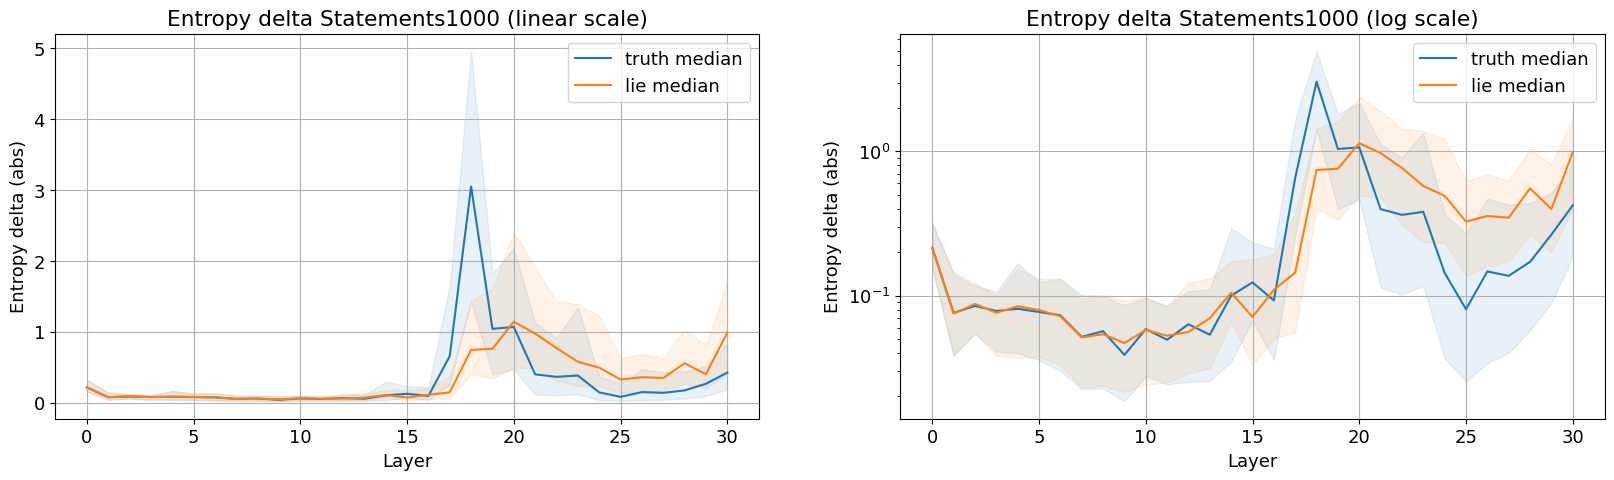

In [55]:
entropy_rate_truth = (entropy_truth[1:]-entropy_truth[:-1]).abs()
entropy_rate_lie = (entropy_lie[1:]-entropy_lie[:-1]).abs()
plot_median_mean(entropy_rate_truth, entropy_rate_lie, title=f'Entropy delta {dataset_name}', y_label='Entropy delta (abs)')

# Cross entropy and cross entropy delta

In [ ]:
cross_entropy_truth = get_cross_entropy(model, dataset['hidden_states_truth'], lenses=lenses)
cross_entropy_lie = get_cross_entropy(model, dataset['hidden_states_lie'], lenses=lenses)

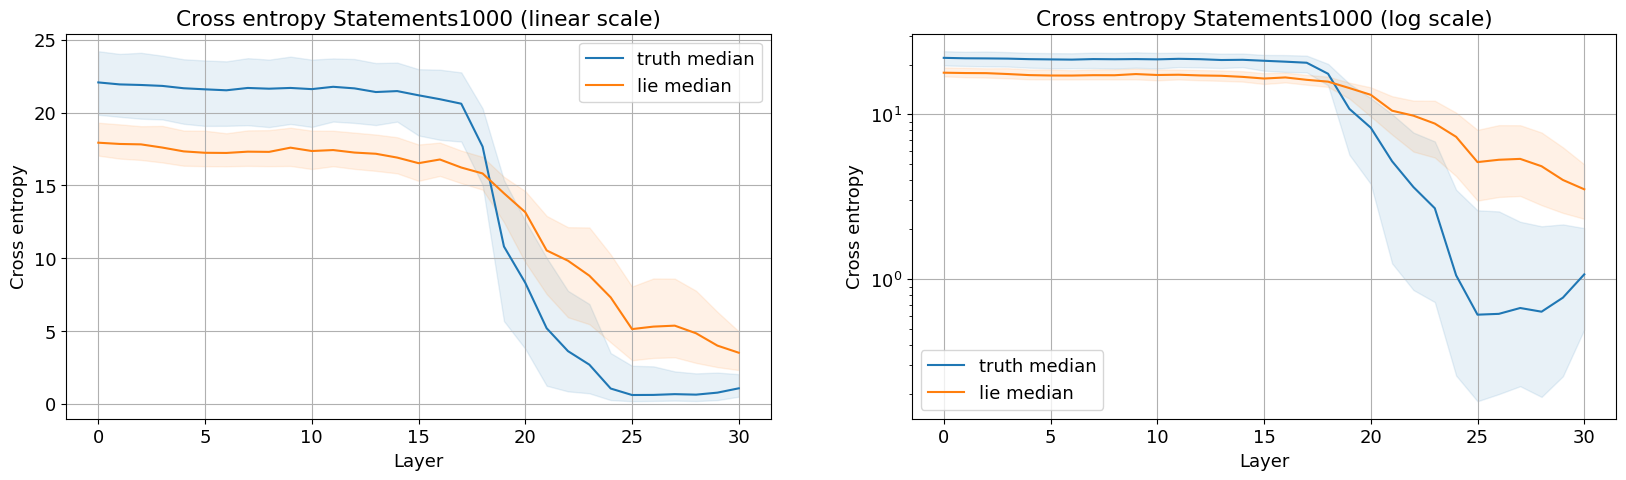

In [56]:
plot_median_mean(cross_entropy_truth, cross_entropy_lie, title=f'Cross entropy {dataset_name}', y_label='Cross entropy')

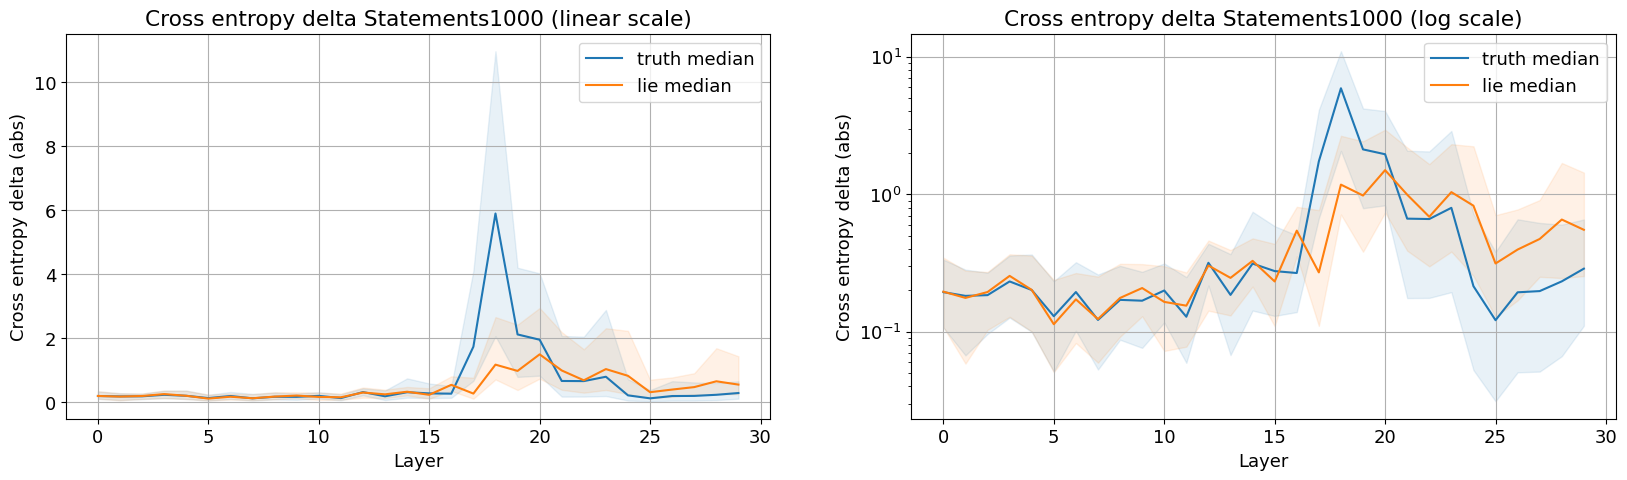

In [57]:
cross_entropy_rate_truth = (cross_entropy_truth[1:]-cross_entropy_truth[:-1]).abs()
cross_entropy_rate_lie = (cross_entropy_lie[1:]-cross_entropy_lie[:-1]).abs()
plot_median_mean(cross_entropy_rate_truth, cross_entropy_rate_lie, title=f'Cross entropy delta {dataset_name}', y_label='Cross entropy delta (abs)')

# Probability

In [49]:
# probability predicted token
predicted_truth_tokens = np.array(dataset['answer_tokens_truth'])[:,0] # the target token is the first answer token
prob_truth = get_probability(model, dataset['hidden_states_truth'], lenses, target_token=predicted_truth_tokens)
predicted_lie_tokens = np.array(dataset['answer_tokens_lie'])[:,0] # the target token is the first answer token
prob_lie = get_probability(model, dataset['hidden_states_lie'], lenses, target_token=predicted_lie_tokens)

# probability truth token
prob_lie_track_truth_token = get_probability(model, dataset['hidden_states_lie'], lenses, target_token=predicted_truth_tokens)

# probability lie token
prob_truth_track_lie_token = get_probability(model, dataset['hidden_states_truth'], lenses, target_token=predicted_lie_tokens)


100%|██████████| 32/32 [00:01<00:00, 16.07it/s]


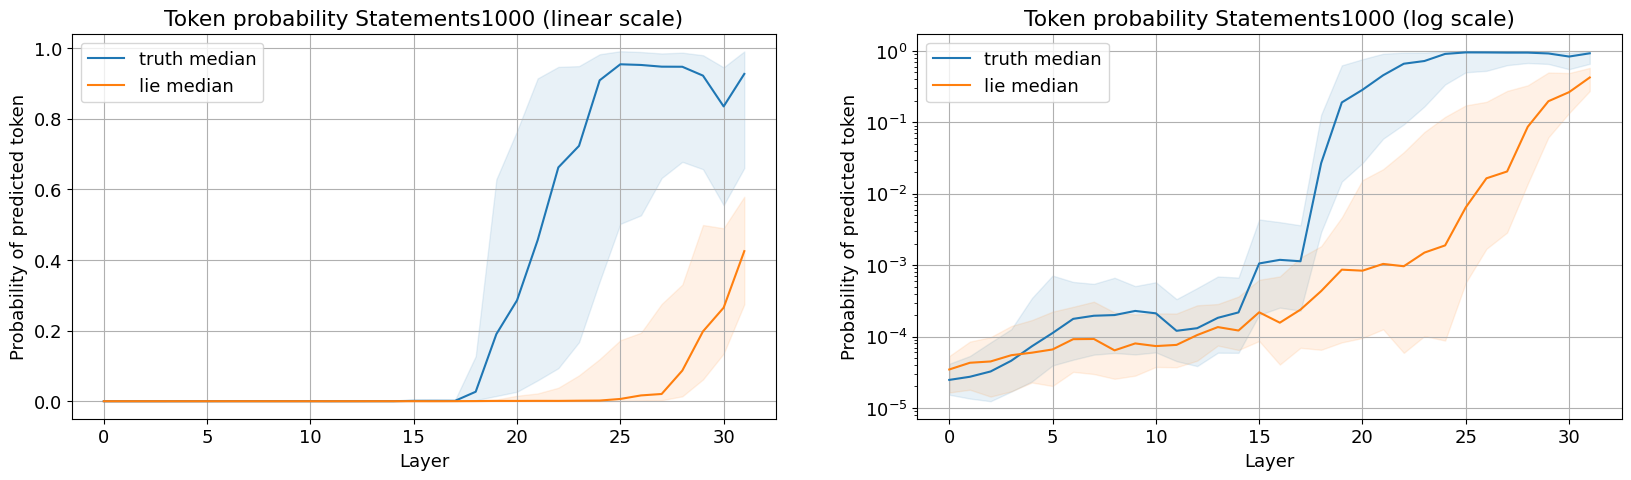

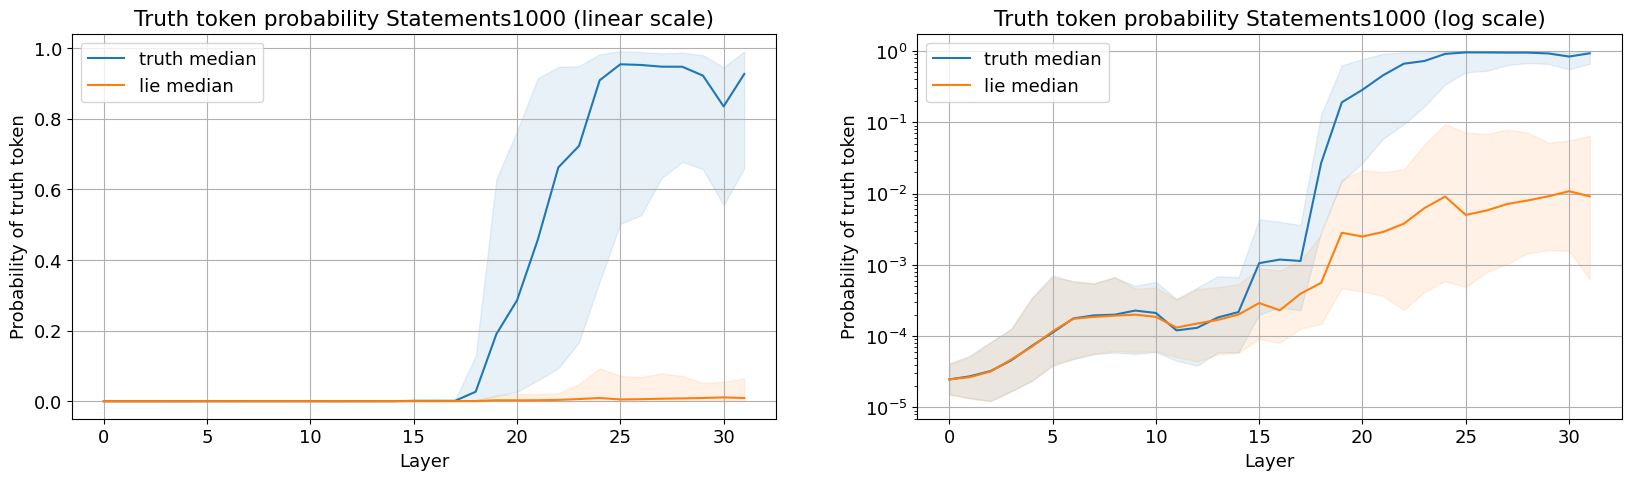

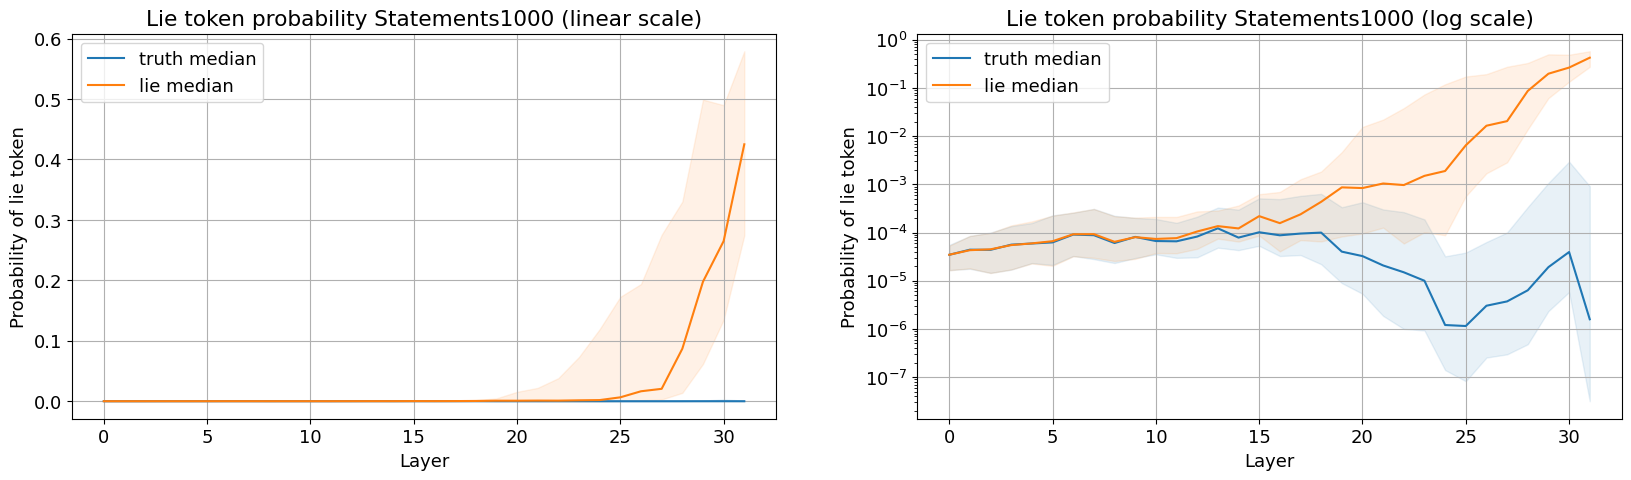

In [58]:
plot_median_mean(prob_truth, prob_lie, title=f'Token probability {dataset_name}', y_label='Probability of predicted token')
plot_median_mean(prob_truth, prob_lie_track_truth_token, title=f'Truth token probability {dataset_name}', y_label='Probability of truth token')
plot_median_mean(prob_truth_track_lie_token, prob_lie, title=f'Lie token probability {dataset_name}', y_label='Probability of lie token')


In [61]:
# track probability of top k tokens
top_k_prob_truth = torch.zeros((k,)+prob_truth.shape)
top_k_prob_lie = torch.zeros((k,)+prob_lie.shape)

top_k_truth_tokens = torch.topk(unembed(model, dataset['hidden_states_truth'][-1]), k, dim=-1)
top_k_lie_tokens = torch.topk(unembed(model, dataset['hidden_states_lie'][-1]), k, dim=-1)

for i in range(k):
    top_k_prob_truth[i] = get_probability(model, dataset['hidden_states_truth'], lenses, target_token=top_k_truth_tokens.indices[:,i])
    top_k_prob_lie[i] = get_probability(model, dataset['hidden_states_lie'], lenses, target_token=top_k_lie_tokens.indices[:,i])


 34%|███▍      | 11/32 [00:00<00:01, 16.30it/s]

100%|██████████| 32/32 [00:01<00:00, 16.64it/s]


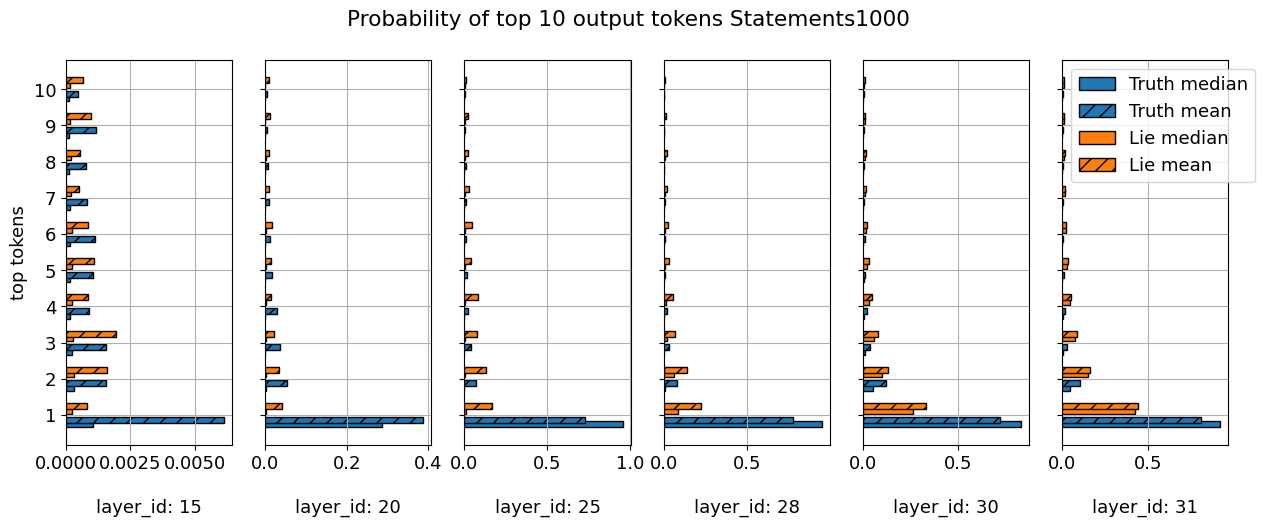

In [62]:
selected_layers = [15, 20, 25, 28, 30, 31]
prob_truth_means, prob_truth_medians = top_k_prob_truth.mean(dim=-1), top_k_prob_truth.median(dim=-1).values
plot_h_bar(top_k_prob_truth, top_k_prob_lie, selected_layers, title=f'Probability of top {k} output tokens {dataset_name}')

In [69]:
top_k_matching_truth = find_matching_tokens(tokenizer, k, top_k_truth_tokens.indices)
top_k_matching_lie = find_matching_tokens(tokenizer, k, top_k_lie_tokens.indices)

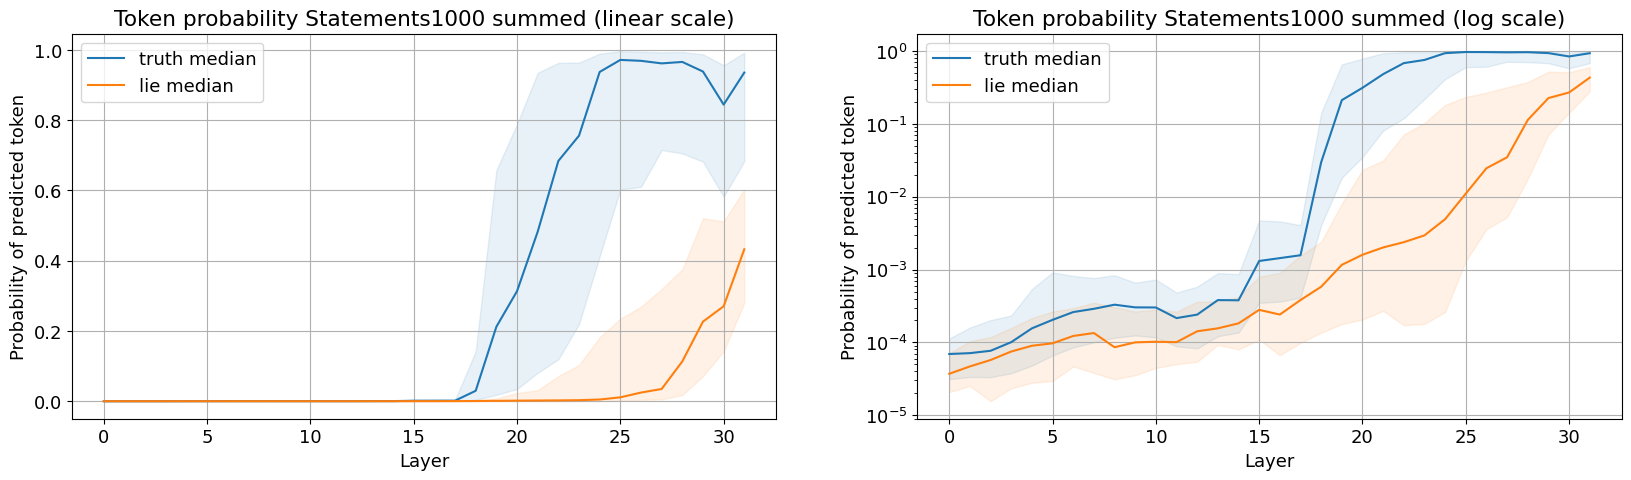

In [71]:
# sum over all prob that match tokens that are considered
new_shape = (k, 1, num_samples)
prob_truth_sums = (top_k_prob_truth*torch.transpose(top_k_matching_truth, 0,1).unsqueeze(1)).sum(dim=0)
prob_lie_sums = (top_k_prob_lie*torch.transpose(top_k_matching_lie, 0,1).unsqueeze(1)).sum(dim=0)
plot_median_mean(prob_truth_sums, prob_lie_sums, title=f'Token probability {dataset_name} summed', y_label='Probability of predicted token')

# KL divergence

In [73]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'], lenses, mode='last')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'], lenses, mode='last')

100%|██████████| 31/31 [00:05<00:00,  5.68it/s]


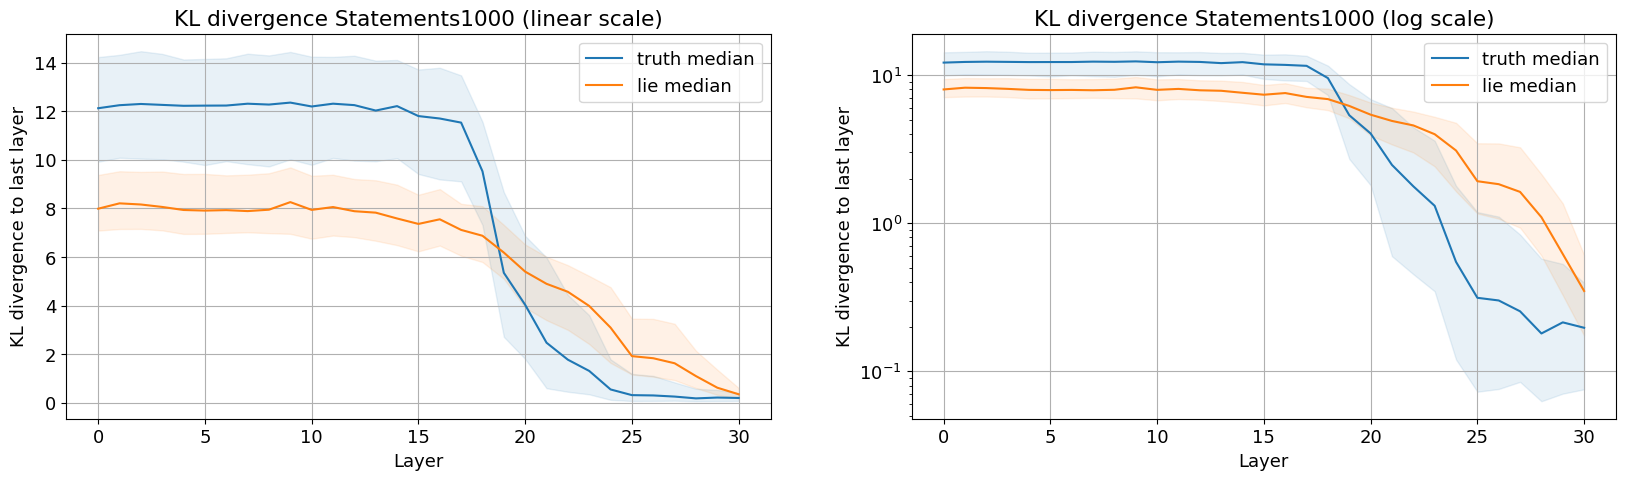

In [74]:
plot_median_mean(KL_truth, KL_lie, title=f'KL divergence {dataset_name}', y_label=f'KL divergence to last layer')

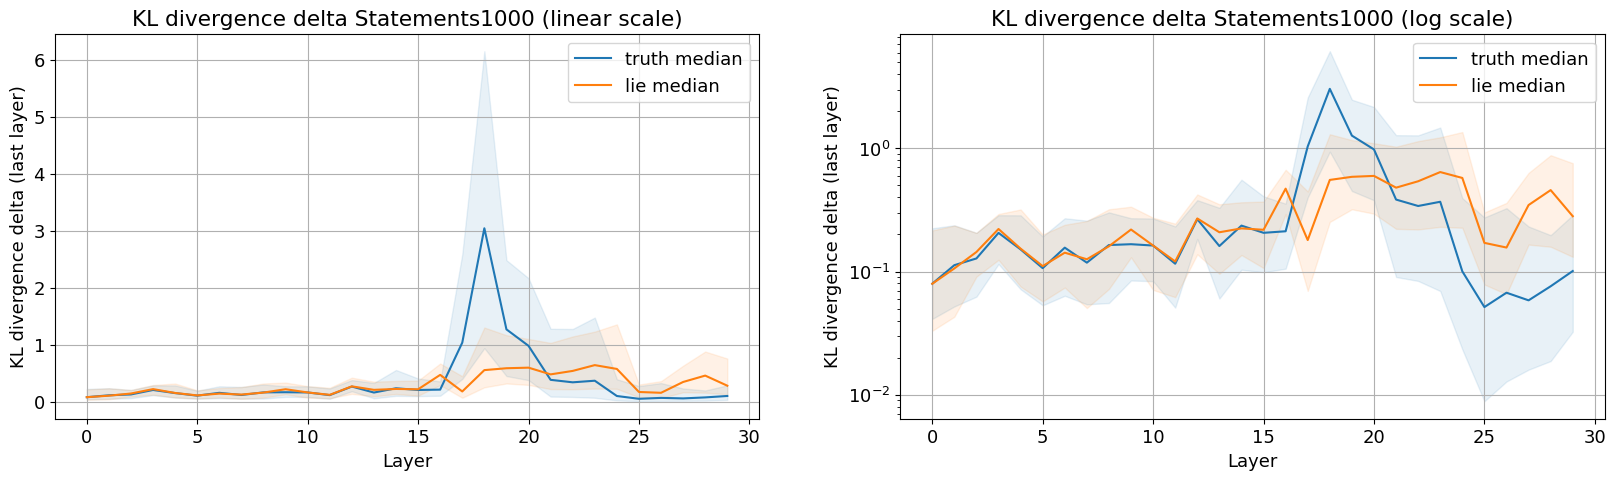

In [75]:
KL_truth_rate = torch.abs(KL_truth[1:]-KL_truth[:-1])
KL_lie_rate = torch.abs(KL_lie[1:]-KL_lie[:-1])
plot_median_mean(KL_truth_rate, KL_lie_rate, title=f'KL divergence delta {dataset_name}', y_label=f'KL divergence delta (last layer)')

# Similarity of 10 most likely output tokens

In [76]:
top_k_truth_tokens_embedded = embed(model, top_k_truth_tokens.indices)
top_k_lie_tokens_embedded = embed(model, top_k_lie_tokens.indices)

truth_token_dist = pdist(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_dist = pdist(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

truth_token_sim = pcossim(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_sim = pcossim(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

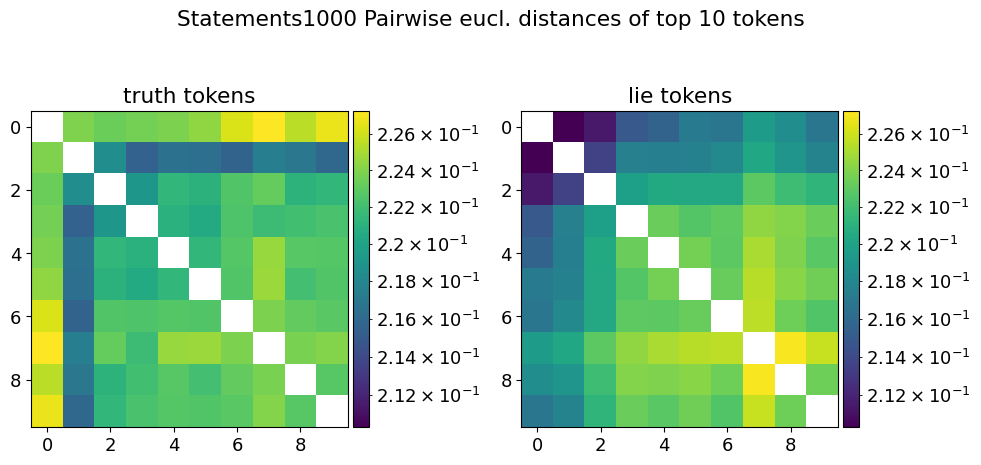

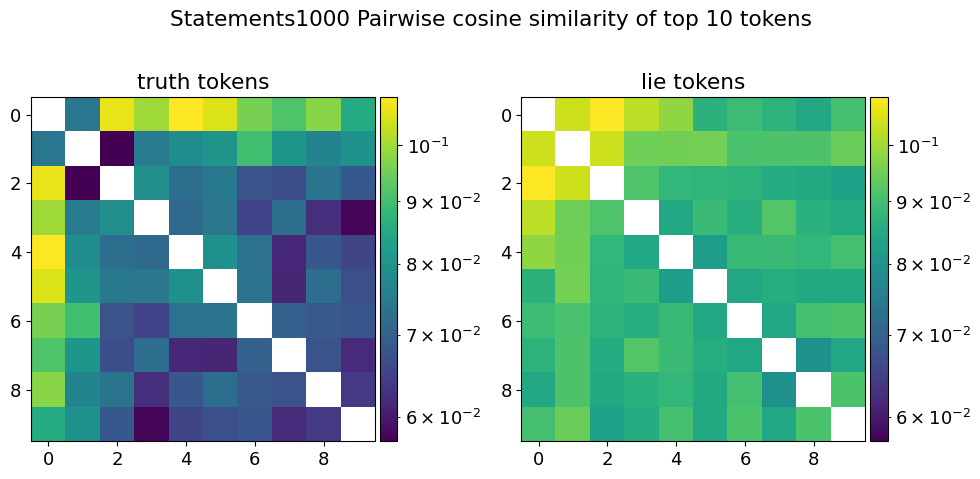

In [77]:
plot_distance_matrix(truth_token_dist, lie_token_dist, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=f"{dataset_name} Pairwise eucl. distances of top {k} tokens", norm=True)

plot_distance_matrix(truth_token_sim, lie_token_sim, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=f"{dataset_name} Pairwise cosine similarity of top {k} tokens", norm=True)